ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

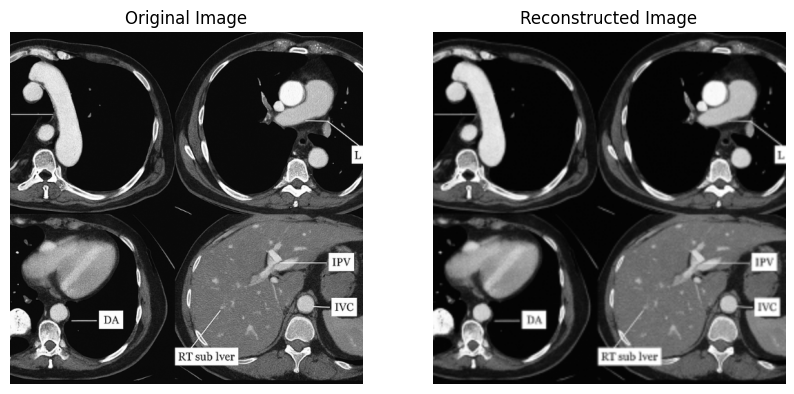

PSNR: 26.16397078280023 dB
SSIM: 0.8555789853321131


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

In [15]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    # Ensure audio can hold the data
    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    # Embed data into audio samples
    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    # Save modified audio
    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command)

# Load original image
original_image = cv2.imread('ct1.png', cv2.IMREAD_GRAYSCALE)

# Resize image to 256x256
compressed_image = cv2.resize(original_image, (256, 256))

# Flatten image and shuffle pixels
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])  # Save original indices
np.random.shuffle(indices)  # Shuffle indices

shuffled_flat_image = flat_image[indices]  # Apply shuffle
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

# Save images
cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)  # Save indices for reconstruction

# Extract audio from video
video_file = 'input.mp4'
audio_file = 'extracted_audio2.wav'
extract_audio(video_file, audio_file)

# Embed the shuffled image into the extracted audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    # Extract data bits from audio samples
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]

    return np.array(data_bytes, dtype=np.uint8)

# Extract the shuffled image data from the audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Load shuffle indices
indices = np.load('shuffle_indices2.npy')  # Load original shuffle indices

# Reverse the shuffling
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data  # Restore original order
reconstructed_image = reconstructed_flat.reshape((256, 256))

# Resize the reconstructed image back to original size
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))

# Save reconstructed image
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate PSNR and SSIM
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images in Jupyter Notebook
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.show()

# Print PSNR and SSIM values
print(f"PSNR: {psnr_value} dB")
print(f"SSIM: {ssim_value}")

# Add the audio with embedded image back into the video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)


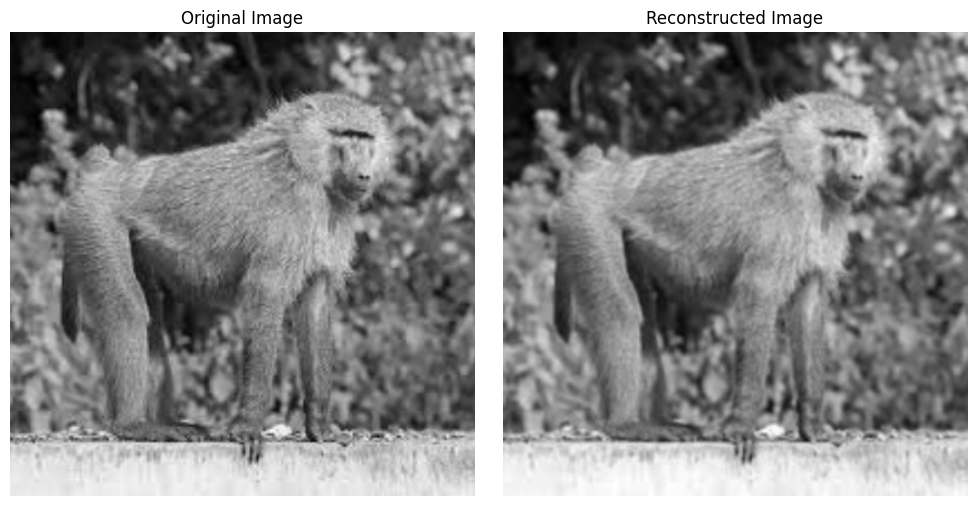

PSNR: 38.89 dB
SSIM: 0.9759

Total Execution Time: 0.80 seconds


In [9]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (256, 256))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio23.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((256, 256))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")



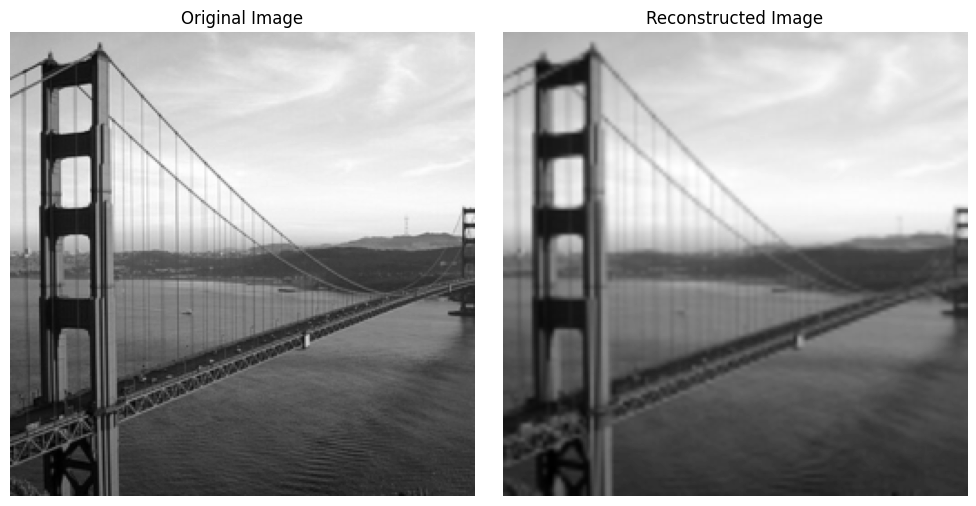

PSNR: 27.65 dB
SSIM: 0.8507

Total Execution Time: 0.63 seconds


In [11]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('bridge.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (128, 128))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio23.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((128, 128))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")


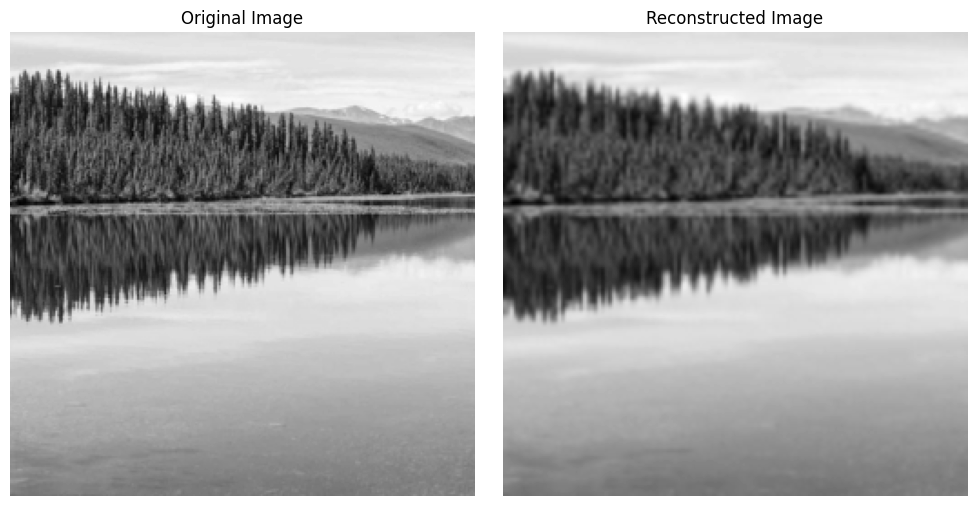

PSNR: 28.38 dB
SSIM: 0.8818

Total Execution Time: 0.58 seconds


In [12]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('lake.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (128, 128))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio23.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((128, 128))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")


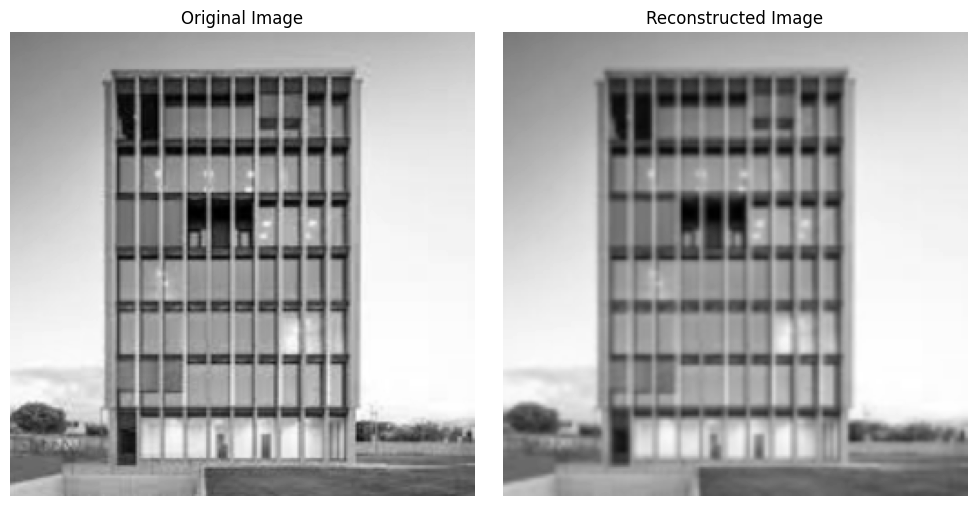

PSNR: 28.07 dB
SSIM: 0.9224

Total Execution Time: 0.86 seconds


In [8]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('building.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (128, 128))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio22.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((128, 128))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")


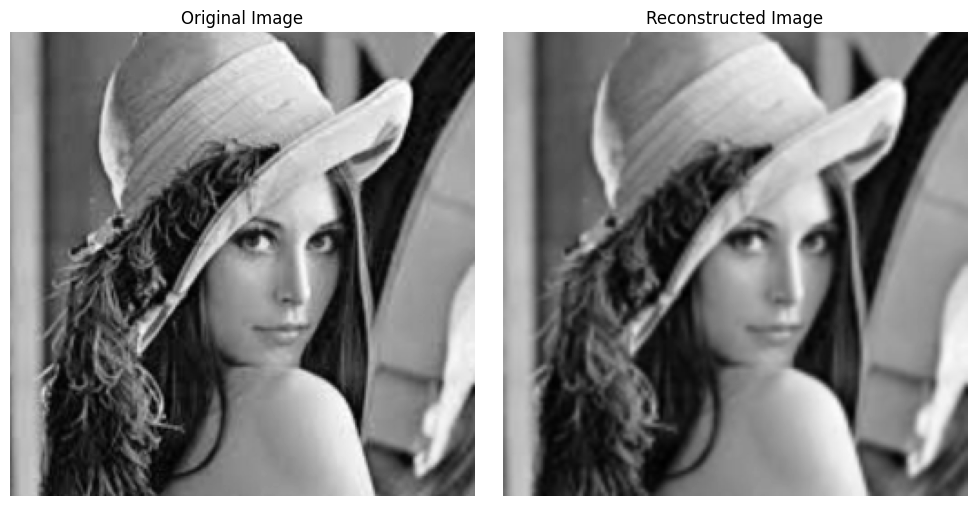

PSNR: 30.35 dB
SSIM: 0.9375

Total Execution Time: 0.52 seconds


In [7]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('lena1.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (128, 128))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio21.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((128, 128))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")


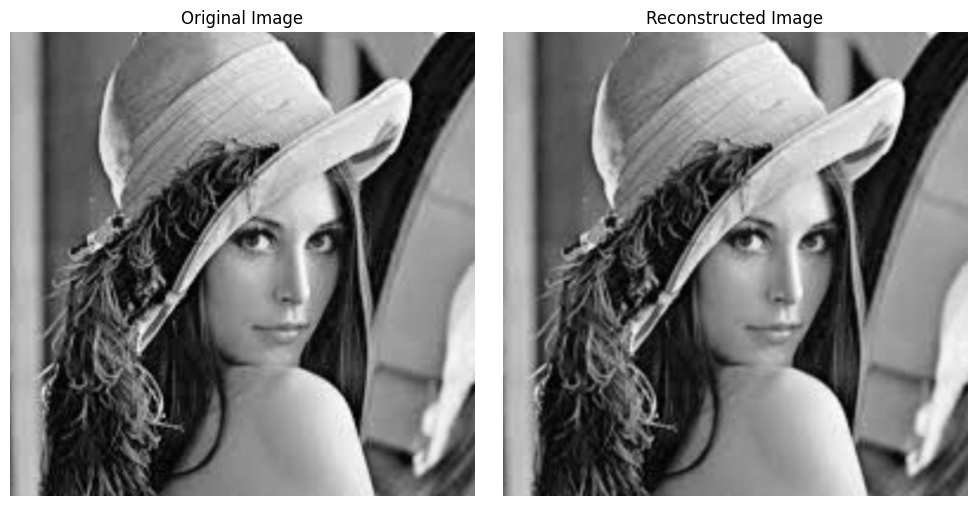

PSNR: 45.42 dB
SSIM: 0.9938

Total Execution Time: 1.66 seconds


In [4]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import time

# Start measuring total time
start_time = time.time()

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Function to extract data from audio using LSB
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())
    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]
    return np.array(data_bytes, dtype=np.uint8)

# Load and process original image
original_image = cv2.imread('lena2.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (512, 512))
flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)
shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT2.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT2.png', shuffled_compressed_image)
np.save('shuffle_indices2.npy', indices)

# Extract audio from video
video_file = 'input5.mp4'
audio_file = 'extracted_audio23.wav'
extract_audio(video_file, audio_file)

# Embed shuffled image into audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image2.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract image from audio
extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

# Reverse the shuffling
indices = np.load('shuffle_indices2.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((512, 512))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))
cv2.imwrite('reconstructed_CT2.png', reconstructed_image_resized)

# Calculate metrics
psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

# Display images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Print results
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

# Add modified audio back to video
output_video_file = 'video_with_embedded_audio2.mp4'
add_audio_to_video(video_file, output_audio_with_image, output_video_file)

# End time and print total duration
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Execution Time: {total_time:.2f} seconds")


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

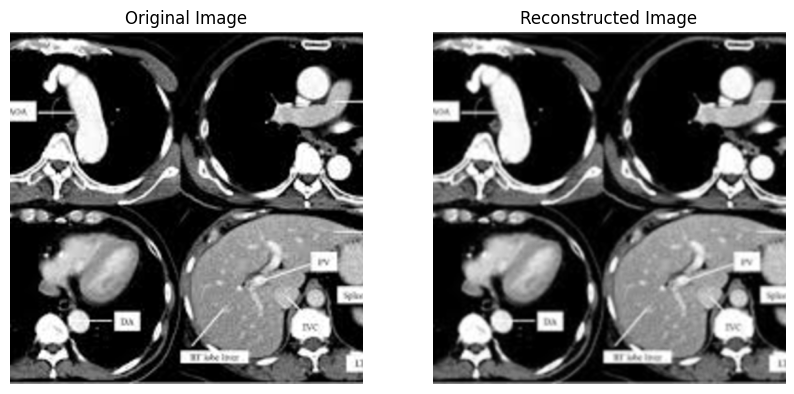

PSNR: 34.12832150540026 dB
SSIM: 0.9737552240995445


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex

In [15]:
import cv2
import numpy as np
from pydub import AudioSegment
import subprocess
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
import random

# Function to extract audio from video
def extract_audio(video_file, output_audio_file):
    command = ['ffmpeg', '-i', video_file, '-q:a', '0', '-map', 'a', output_audio_file]
    subprocess.run(command)

# Function to embed data into audio using LSB
def embed_data_in_audio(audio_file, data, output_audio_file):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    assert len(data) * 8 <= len(audio_samples), "Audio file is too short to hold the data."

    data_bits = ''.join(format(byte, '08b') for byte in data)
    for i in range(len(data_bits)):
        audio_samples[i] = (audio_samples[i] & ~1) | int(data_bits[i])

    modified_audio = audio._spawn(audio_samples.tobytes())
    modified_audio.export(output_audio_file, format="wav")

# Function to add the audio back to the video
def add_audio_to_video(video_file, audio_file, output_video_file):
    command = ['ffmpeg', '-i', video_file, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', output_video_file]
    subprocess.run(command)

# Function to apply frame drop attack
def frame_drop_attack(video_path, output_path, drop_rate=0.2):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Randomly drop frames
        if random.random() > drop_rate:
            out.write(frame)

        frame_idx += 1

    cap.release()
    out.release()

# Load original image
original_image = cv2.imread('CT.png', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.resize(original_image, (256, 256))

flat_image = compressed_image.flatten()
indices = np.arange(flat_image.shape[0])
np.random.shuffle(indices)

shuffled_flat_image = flat_image[indices]
shuffled_compressed_image = shuffled_flat_image.reshape(compressed_image.shape)

cv2.imwrite('compressed_CT1.png', compressed_image)
cv2.imwrite('shuffled_compressed_CT1.png', shuffled_compressed_image)
np.save('shuffle_indices1.npy', indices)

# Extract audio from original video
video_file = 'input.mp4'
audio_file = 'extracted_audio1.wav'
extract_audio(video_file, audio_file)

# Embed image data in audio
shuffled_image_data = shuffled_compressed_image.flatten().astype(np.uint8)
output_audio_with_image = 'audio_with_embedded_image1.wav'
embed_data_in_audio(audio_file, shuffled_image_data, output_audio_with_image)

# Extract data from audio
def extract_data_from_audio(audio_file, data_length):
    audio = AudioSegment.from_file(audio_file)
    audio_samples = np.array(audio.get_array_of_samples())

    data_bits = [str(audio_samples[i] & 1) for i in range(data_length * 8)]
    data_bytes = [int(''.join(data_bits[i:i + 8]), 2) for i in range(0, len(data_bits), 8)]

    return np.array(data_bytes, dtype=np.uint8)

extracted_image_data = extract_data_from_audio(output_audio_with_image, shuffled_compressed_image.size)
extracted_shuffled_image = extracted_image_data.reshape(shuffled_compressed_image.shape)

indices = np.load('shuffle_indices1.npy')
reconstructed_flat = np.zeros_like(extracted_image_data)
reconstructed_flat[indices] = extracted_image_data
reconstructed_image = reconstructed_flat.reshape((256, 256))
reconstructed_image_resized = cv2.resize(reconstructed_image, (original_image.shape[1], original_image.shape[0]))

cv2.imwrite('reconstructed_CT1.png', reconstructed_image_resized)

psnr_value = psnr(original_image, reconstructed_image_resized)
ssim_value = ssim(original_image, reconstructed_image_resized)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(reconstructed_image_resized, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')
plt.show()

print(f"PSNR: {psnr_value} dB")
print(f"SSIM: {ssim_value}")

# Apply frame drop attack
attacked_video_file = 'video_with_frame_drop.mp4'
frame_drop_attack(video_file, attacked_video_file, drop_rate=0.2)

# Merge audio with embedded image back to attacked video
output_video_file = 'attacked_video_with_embedded_audio.mp4'
add_audio_to_video(attacked_video_file, output_audio_with_image, output_video_file)


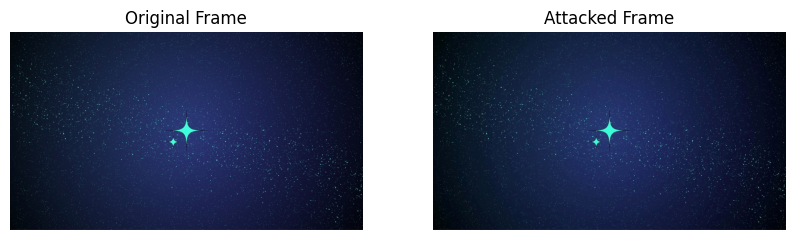

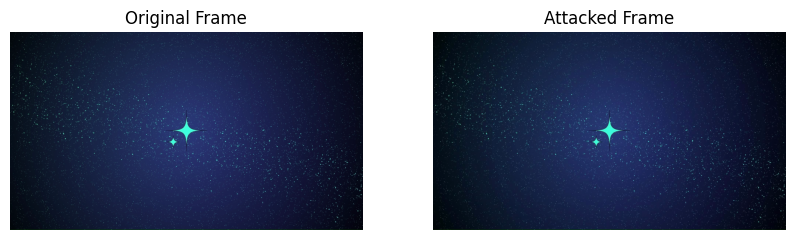

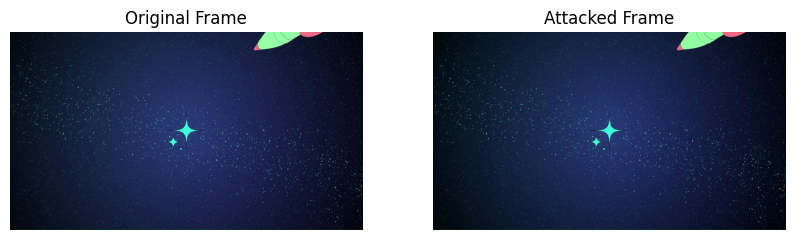

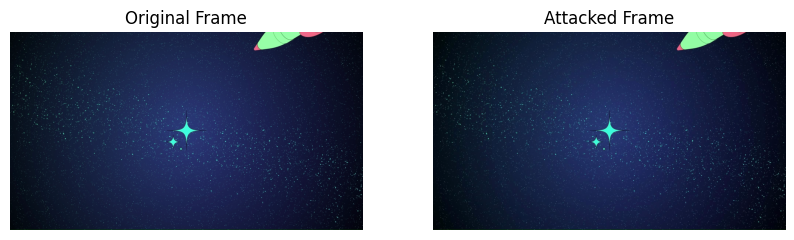

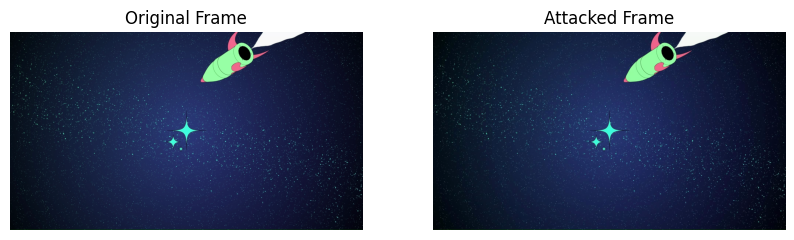

In [18]:
# Show and save some frames before and after frame drop
def show_frame_differences(original_video, attacked_video, num_frames=5):
    cap_orig = cv2.VideoCapture(original_video)
    cap_attacked = cv2.VideoCapture(attacked_video)

    frames_orig = []
    frames_attacked = []

    for _ in range(num_frames):
        ret1, frame1 = cap_orig.read()
        ret2, frame2 = cap_attacked.read()
        if not (ret1 and ret2):
            break
        frames_orig.append(frame1)
        frames_attacked.append(frame2)

    cap_orig.release()
    cap_attacked.release()

    # Show side-by-side
    for i in range(len(frames_orig)):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(cv2.cvtColor(frames_orig[i], cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Frame')
        axes[0].axis('off')
        axes[1].imshow(cv2.cvtColor(frames_attacked[i], cv2.COLOR_BGR2RGB))
        axes[1].set_title('Attacked Frame')
        axes[1].axis('off')
        plt.show()

show_frame_differences(video_file, attacked_video_file, num_frames=5)

